# Proyecto: Predicción de la edad de una persona

**Dificultad:** fácil


En este proyecto se propone la implementación de una CNN para predecir la edad de una persona a partir de una fotografía. Para esto vamos a utilizar la base de datos IMFDB ([Indian Movie Face database](https://datahack.analyticsvidhya.com/contest/practice-problem-age-detection/)) que contiene unas 20 mil imágenes de 100 actores indios recopilados de más de 100 vídeos. Las imágenes se han recortado manualmente, buscando un alto grado de variabilidad en términos de escala, postura, expresión, iluminación, edad, resolución, oclusión y composición.

En este proyecto veremos como cargar esta base de datos y prepararla para entrenar y evaluar una CNN. A continuación diseñaremos la CNN a utilizar, la entrenaremos y evaluaremos. Por último aplicaremos aumentado de datos para mejorar el resultado obtenido.



## 1. Descargar la base de datos

En este primer punto vamos a descargar de Internet la base de datos a utilizar, a continuación la descomprimiremos y cargaremos los datos (etiquetas e imágenes) en memoria. Por último mostraremos algunas imágenes junto con la etiqueta asociada.

['MIDDLE' 'OLD' 'YOUNG']


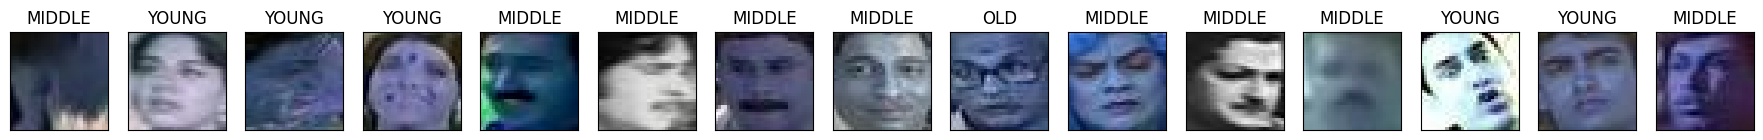

In [3]:
# Cargamos las dependencias necesarias y fijamos las semillas...
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2

tf.random.set_seed(1)  # Fijamos la semilla de TF
np.random.seed(1)  # Fijamos la semilla


# Descargamos y descomprimimos la base de datos...
!wget -q http://www.dlsi.ua.es/~jgallego/deepraltamira/dataset_age.zip
!unzip -qo dataset_age.zip


# Cargamos el CSV con la descripción de la BD usando Pandas...
pd_data = pd.read_csv('data.csv')


# Cargamos las imágenes asociadas al CSV...
x = []
for img_name in pd_data.ID:
    x.append( cv2.imread('dataset/' + img_name) )


# Guardamos la etiqueta asociadas a cada imagen...
y = pd_data.Class
print(np.unique(y))

# Mostramos algunas imágenes...

# TODO - muestra 15 imágenes aleatorias junto a su etiqueta utilizando las variables "x" e "y"
n = 15
index = np.random.randint(len(x), size=n)
plt.figure(figsize=(n*1.5, 1.5))
for i in np.arange(n):
    ax = plt.subplot(1,n,i+1)
    ax.set_title('{}'.format( y[index[i]] ))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(x[index[i]])
plt.show()


## 2. Preparar los datos para la red

En este paso vamos perparar los datos para poder entrenar y evaluar el modelo de red. Para esto seguiremos los siguientes pasos:

- Primero transformaremos a decimal el formato de los datos de las imágenes y normalizaremos sus valores al rango [0,1].

- A continuación prepararemos también las etiquetas, transformando las etiquetas (cadenas de texto) a números y después a formato one-hot.

- Por último crearemos las particiones de train y test (asignando un 80% de los datos para el entrenamiento y el resto para el test) y mostraremos también las dimensiones de los datos obtenidos finalmente.

In [4]:
from sklearn.model_selection import train_test_split

# Normalizamos los datos de las imágenes en el rango [0,1]...

# TODO - Transforma el array "x" a decimal
x = np.float32(x)

# TODO - Normaliza los datos en el rango 0-1
x /= 255


# Transformamos las etiquetas (tipo texto) a números y después a formato one-hot...
lb = LabelEncoder()
y = lb.fit_transform(pd_data.Class)  # Para transformar las etiquetas tipo texto a números utilizamos la clase "LabelEncoder"

# TODO - Transforma los datos de la variable "y" a formato one-hot
y = tf.keras.utils.to_categorical(y, len(np.unique(y)))


# Creamos las particiones de train y test...

# TODO - Utiliza el método "train_test_split" para dividir las variables "x" e "y"
#        en los datos de entrenamiento (x_train, y_train) y los de test (x_test, y_test)
#        Asigna un 80% de los datos para entrenamiento y un 20% para el test.
#        Puedes ver un ejemplo de como realizar esto en:
#        https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=123)


# Mostramos (de nuevo) las dimensiones de los datos...

# TODO - Muestra la forma o dimensiones de los datos de entrenamiento y evaluación
print(x_train.shape)
print(x_test.shape)
print()

# TODO - Muestra el valor mínimo, máximo y medio del contenido de los arrays "x_train" y "x_test"
#        Para esto puedes utilizar las funciones de numpy: np.min(x_train), np.max(), np.mean()
print(np.min(x_train), np.max(x_train), np.mean(x_train))
print(np.min(x_test), np.max(x_test), np.mean(x_test))



(15924, 32, 32, 3)
(3982, 32, 32, 3)

0.0 1.0 0.35760745
0.0 1.0 0.3554493


## 3. Definir el modelo de red

Define un modelo de red con la siguiente estructura:

1. Una capa convolucional con 32 filtros de tamaño 3x3 y con función de activación ReLU. Recuerda que en esta capa, al ser la capa de entrada, tienes que indicar el `input_shape` con la forma de los datos de entrada.
2. Una capa convolucional con 32 filtros de tamaño 3x3 y con función de activación ReLU.
3. Una capa de Max Pooling de tamaño 2x2.
4. Una capa de Dropout de 0.25.
5. Una capa convolucional con 64 filtros de tamaño 3x3 y con función de activación ReLU.
6. Una capa convolucional con 64 filtros de tamaño 3x3 y con función de activación ReLU.
7. Una capa de Max Pooling de tamaño 2x2.
8. Una capa de Dropout de 0.25.
9. Una capa Flatten.
10. Una capa densa con 512 neuronas y con función de activación ReLU.
11. Una capa de Dropout de 0.5.
12. Una capa densa para la salida con 3 neuronas y con función de activación SoftMax.

Compila este modelo para que utilice la función de loss "`categorical_crossentropy`", el optimizador "`adam`" y añade además la métrica "`accuracy`".

Entrena este modelo durante 25 épocas con un batch de tamaño 32. Indica que utilice como datos de validación `x_test` e `y_test`, y guarda el resultado de este entrenamiento en la variable `history`.

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

model1 = Sequential() # TODO - Define el modelo de red especificado en las instrucciones superiores.
model1.add(Conv2D(32, (3, 3), activation="relu", input_shape=x.shape[1:]))
model1.add(Conv2D(32, (3, 3), activation="relu" ))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(.25))

model1.add(Conv2D(64, (3,3), activation="relu"))
model1.add(Conv2D(64, (3,3), activation="relu"))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(.25))
model1.add(Flatten())

model1.add(Dense(512, activation="relu"))
model1.add(Dropout(.5))
model1.add(Dense(3, activation="softmax"))


# TODO - Compila el modelo de red
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )


## 4. Mostrar las curvas de aprendizaje y evaluar usando el test set

En este paso vamos a mostrar las curvas de aprendizaje utilizando la variable `history` que hemos guardado en el paso anterior.

Además evaluaremos el modelo de red entrenado utilizando los datos del conjunto de test.

Analiza las curvas de aprendizaje y el resultado obtenido, ¿la red está aprendiendo correctamente?

Epoch 1/25
498/498 [==============================] - 16s 8ms/step - loss: 0.8736 - accuracy: 0.5885 - val_loss: 0.8954 - val_accuracy: 0.5773
Epoch 2/25
498/498 [==============================] - 4s 8ms/step - loss: 0.7747 - accuracy: 0.6552 - val_loss: 0.7545 - val_accuracy: 0.6647
Epoch 3/25
498/498 [==============================] - 3s 6ms/step - loss: 0.7216 - accuracy: 0.6831 - val_loss: 0.7086 - val_accuracy: 0.6786
Epoch 4/25
498/498 [==============================] - 3s 6ms/step - loss: 0.6929 - accuracy: 0.6954 - val_loss: 0.6636 - val_accuracy: 0.7039
Epoch 5/25
498/498 [==============================] - 3s 6ms/step - loss: 0.6608 - accuracy: 0.7138 - val_loss: 0.6775 - val_accuracy: 0.6944
Epoch 6/25
498/498 [==============================] - 4s 8ms/step - loss: 0.6390 - accuracy: 0.7208 - val_loss: 0.6664 - val_accuracy: 0.7084
Epoch 7/25
498/498 [==============================] - 3s 6ms/step - loss: 0.6117 - accuracy: 0.7347 - val_loss: 0.6559 - val_accuracy: 0.7160
Epoch

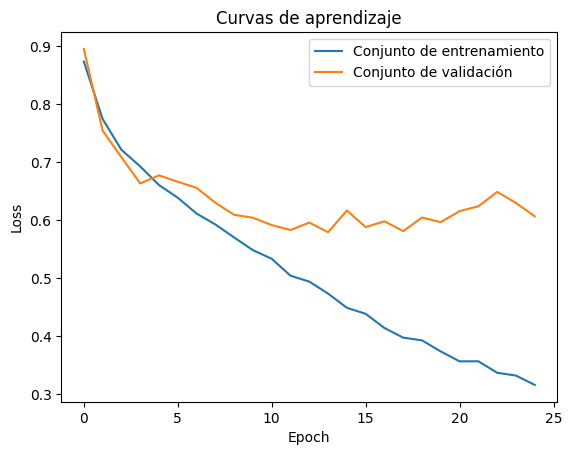

Resultado en el test set:
Test loss: 0.6069
Test accuracy: 77.70%


In [6]:
# TODO - Entrena la red y guarda el log de entrenamiento en la variable "history"
history = model1.fit(x_train, y_train,
                     validation_data=(x_test, y_test),
                     batch_size= 32,
                     epochs= 25,
                     verbose=1)

"""
Mostramos las curvas de aprendizaje y evaluamos usando el test set
"""

# TODO - Define la función para mostrar las curvas de aprendizaje
# -----------------------------
def plot_learning_curves(hist):
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.title('Curvas de aprendizaje')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Conjunto de entrenamiento', 'Conjunto de validación'], loc='upper right')
  plt.show()

# TODO - Llama a la función con la variable "history" que hemos guardado durante el entrenamiento.
plot_learning_curves(history)


# TODO - Evalúa el modelo de red aprendido con los datos de test y muestra el resultado.
score =  model1.evaluate(x_test, y_test, verbose=0)

print('Resultado en el test set:')
print('Test loss: {:0.4f}'.format(score[0]))
print('Test accuracy: {:0.2f}%'.format(score[1] * 100))

## 5. Aplicar aumentado de datos

Por último, dado que el modelo anterior estaba realizando overfitting al conjunto de datos de entrenamiento, vamos a aplicar aumentado de datos para intentar solucionar este problema.

Para esto vamos a utilizar la clase [`ImageDataGenerator` de Keras](https://keras.io/preprocessing/image/#imagedatagenerator-class), aplicando las siguientes transformaciones de forma aleatoria:

* Rotaciones en el rango [0, 5].
* Traslaciones horizontales y verticales (0.1, es decir, un 10% del tamaño).
* Flips horizontales.

Entrena de nuevo la red durante 25 épocas y con batch de tamaño 32 utilizando aumentado de datos. Muestra las curvas de aprendizaje y evalúa el modelo usando el test set.

Epoch 1/25
498/498 [==============================] - 13s 24ms/step - loss: 0.6621 - accuracy: 0.7217 - val_loss: 0.5829 - val_accuracy: 0.7562
Epoch 2/25
498/498 [==============================] - 12s 24ms/step - loss: 0.6310 - accuracy: 0.7275 - val_loss: 0.6298 - val_accuracy: 0.7310
Epoch 3/25
498/498 [==============================] - 12s 24ms/step - loss: 0.6167 - accuracy: 0.7351 - val_loss: 0.5908 - val_accuracy: 0.7654
Epoch 4/25
498/498 [==============================] - 12s 24ms/step - loss: 0.6137 - accuracy: 0.7367 - val_loss: 0.5572 - val_accuracy: 0.7675
Epoch 5/25
498/498 [==============================] - 12s 23ms/step - loss: 0.6065 - accuracy: 0.7414 - val_loss: 0.6132 - val_accuracy: 0.7499
Epoch 6/25
498/498 [==============================] - 12s 25ms/step - loss: 0.6010 - accuracy: 0.7393 - val_loss: 0.5599 - val_accuracy: 0.7705
Epoch 7/25
498/498 [==============================] - 12s 24ms/step - loss: 0.5874 - accuracy: 0.7476 - val_loss: 0.5560 - val_accuracy:

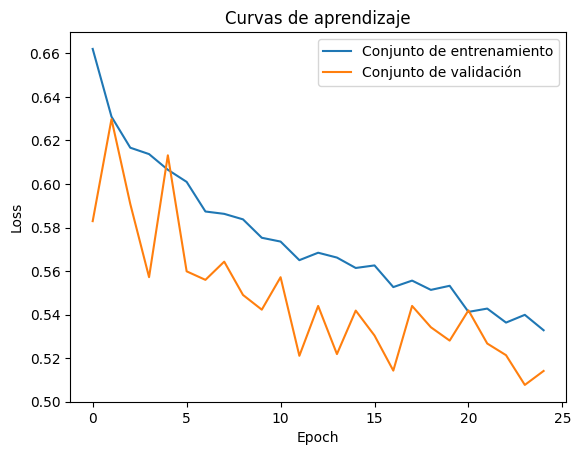

Resultado en el test set:
Test loss: 0.5141
Test accuracy: 77.80%


In [7]:
"""
Aumentado de datos
"""
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# TODO - Crea una instancia de la clase "ImageDataGenerator" con los siguientes parámetros:
#         - rotation_range = 5
#         - width_shift_range = 0.1
#         - height_shift_range = 0.1
#         - horizontal_flip = True
datagen = ImageDataGenerator(rotation_range = 5, width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True)

# TODO - Entrena de nuevo el modelo de red definido anteriormente utilizando aumentado de datos.
#        Para esto recuerda llamar a su método "fit" usando la instancia de la clase
#        "ImageDataGenerator" definida anteriormente. Puedes ver un ejemplo de como realizar esto en:
#        https://keras.io/preprocessing/image/#imagedatagenerator-class
history = model1.fit(datagen.flow(x_train, y_train),
                     validation_data=(x_test, y_test),
                     batch_size= 32,
                     epochs= 25,
                     verbose=1)

# TODO - Muestra las nuevas curvas de aprendizaje obtenidas al aplicar aumentado de datos.
plot_learning_curves(history)


# TODO - Evalúa el nuevo modelo de red con los datos de test y muestra el resultado
score =  model1.evaluate(x_test, y_test, verbose=0)

print('Resultado en el test set:')
print('Test loss: {:0.4f}'.format(score[0]))
print('Test accuracy: {:0.2f}%'.format(score[1] * 100))


## 6. Mejorar el resultado obtenido

Intenta mejorar el resultado obtenido, para esto puedes probar algunas de las siguientes opciones:

* Modificar el modelo de red utilizado (más capas, más filtros, distintos tamaños de kernel, etc.)

* Entrenar durante más épocas.

* Añadir [Batch Normalization](https://keras.io/layers/normalization/#batchnormalization).

* Modificar el rango de las transformaciones aplicadas en el aumentado de datos y/o aplicar [otras transformaciones](https://keras.io/preprocessing/image/#imagedatagenerator-class).